# Para este proyecto, busco extraer los datos del producto y del precio del mismo de la pagina web de Hiper Libertad:
 https://www.hiperlibertad.com.ar/

## 00 - Instalar librerias necesarias:

* Scrapy: para definir "arañas" (spiders) que navegan por sitios web y extraen información estructurad
* Datetime: para definir fecha y hora

In [1]:
# 00- Instalar librerias necesarias:
!pip install scrapy
!pip install datetime

## 01 -  Importar las librerias necesarias:

* scrapy: para seleccionar elementos HTML con selectores CSS
* datetime: para manejar las fechas y horas
* pytz: para trabajar con zonas horarias
* google.colab.files: para subir o descargar archivos desde colab a la computadora

In [2]:
import scrapy
from datetime import datetime
import pytz
from google.colab import files

## 02 -  Desarrollar y guardar el script en el archivo hiper_libertad.py

Se define la araña web y una lista de URLs que corresponden a productos del supermercado Hiper Libertad. Asi mismo, se define la fundion parse, que procesa cada pagina.

En las pruebas se detecto que las etiquetas span que contenien el elemento web con el precio, no siempre se lograban leer por el scrpaper.

Estas son las etiquetas:
*   span.vtex-product-price-1-x-currencyInteger

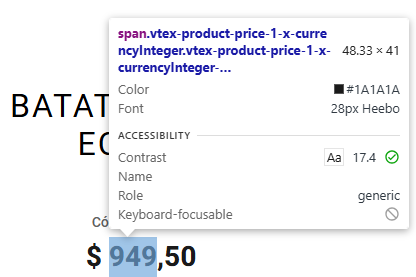
*   span.vtex-product-price-1-x-currencyInteger.vtex-product-price-1-x-currencyInteger--pdp-selling-price
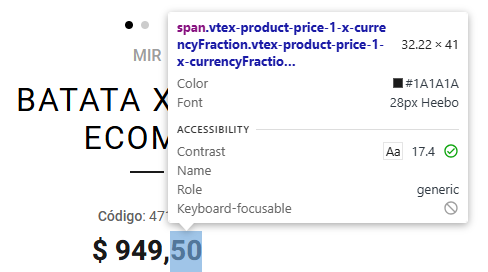


Se detectó que estas etiquetas span solo se leen para productos que estan de oferta y puntualmente, el scrapper lo que lee es el precio normal del elemento (No el de oferta). Para este analisis usaremos estos span para identificar los precios normales, ya que considero que los precios de ofertas son ocasionales.

Ante esta situacion se investigo en la pagina usando las herramientas de desarrollador, buscando el precio completo del elemento en el HTML y se encontro la etiqueta meta meta[property="product:price:amount"], la cual trae el precio y el scrapper la lee correctamente

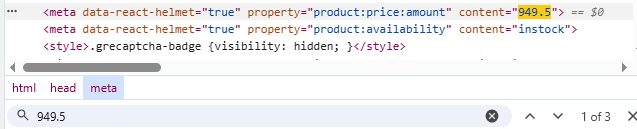

Por lo  usare las etiquetas span para aquellos elementos en oferta (obtener el precio normal) y aquellos que no tengan este valor, aplicare la etiqueta meta para obtener el valor correcto


In [3]:
%%writefile hiper_libertad.py

# 01 - Importo librerias necesarias:
import scrapy
from scrapy.cmdline import execute
from datetime import datetime
import pytz


# 02-  Configuro el la fecha actual:
zona_arg = pytz.timezone('America/Argentina/Buenos_Aires')

hora = datetime.now(zona_arg).time()
fecha = datetime.now().today()

#03- Formato correcto para la fecha y hora:
fHoraMinuto = "%H:%M"
fDiaMesAño = "%d-%m-%Y"

horaActual = hora.strftime(fHoraMinuto)
fechaActual = fecha.strftime(fDiaMesAño)

# prueba de resultado:
#print(f'''
#La fecha actual es: {fechaActual}
#La hora actual es: {horaActual}''')

# 04 - Configuro la araña:
class ProductosSpider(scrapy.Spider):
    name = 'Canasta'
    start_urls = [
        "https://www.hiperlibertad.com.ar/pan-baguete-x-unidad-2/p",
        "https://www.hiperlibertad.com.ar/galletitas-sandwich-mediatarde-x3-107-g/p",
        "https://www.hiperlibertad.com.ar/galletitas-surtido-diversi-n-en-bolsa-400-g/p",
        "https://www.hiperlibertad.com.ar/arroz-blanco-largo-fino-molinos-ala-1-kg/p",
        "https://www.hiperlibertad.com.ar/harina-000-favorita-con-vitaminas-x-1-kg/p",
        "https://www.hiperlibertad.com.ar/papa-cepillada-x-1-kg/p",
        "https://www.hiperlibertad.com.ar/batata-x-500-g/p",
        "https://www.hiperlibertad.com.ar/azucar-ledesma-clasica-1-kg/p",
        "https://www.hiperlibertad.com.ar/dulce-de-leche-clasico-ilolay-400-gr/p",
        "https://www.hiperlibertad.com.ar/cebolla-x-500-g/p",
        "https://www.hiperlibertad.com.ar/manzana-roja-fraccionada-x-1kg/p",
        "https://www.hiperlibertad.com.ar/pollo-fresco-x-un-aprox-2-5kg/p",
        "https://www.hiperlibertad.com.ar/salame-milan-lario-feteado-150g/p",
        "https://www.hiperlibertad.com.ar/huevo-blanco-mediterranea-x6u/p",
        "https://www.hiperlibertad.com.ar/leche-entera-la-seren-sima-mult-vit-3-sachet-x-1-lt/p",
        "https://www.hiperlibertad.com.ar/queso-crema-cl-sico-casancrem-290gr-3/p",
        "https://www.hiperlibertad.com.ar/yogur-bebible-vainilla-la-seren-sima-cl-sico-900gr-2/p",
        "https://www.hiperlibertad.com.ar/manteca-primer-premio-100gr/p",
        "https://www.hiperlibertad.com.ar/aceite-de-girasol-natura-1-5-lt/p",
        "https://www.hiperlibertad.com.ar/sal-final-celusal-paquete-500-gr/p",
        "https://www.hiperlibertad.com.ar/vinagre-vino-alcazar-x-500ml/p",
        "https://www.hiperlibertad.com.ar/caf-cabrales-al-grano-torrado-molido-x-500-gr/p",
        "https://www.hiperlibertad.com.ar/yerba-chamigo-sin-tacc-x-1-kg/p",
        "https://www.hiperlibertad.com.ar/mayonesa-natura-250-cc/p"
    ]

# 05 - Configuro la funcion Parse:

    def parse(self, response):
            nombre_producto = response.css('span.vtex-store-components-3-x-productBrand::text').get()

            # El precio esta dividido en 2 span diferentes (enteros y decimales)
            precio_normal_oferta_entero = response.css("span.vtex-product-price-1-x-currencyInteger::text").getall()
            precio_normal_oferta_decimales =  response.css("span.vtex-product-price-1-x-currencyFraction::text").get()

            # Extraer precio desde el tag meta
            precio_normal = response.css('meta[property="product:price:amount"]::attr(content)').get()

            # Seleccionar el precio normal en caso de oferta, si no el precio  del tag meta

            if precio_normal_oferta_entero:
              precio = f'{ precio_normal_oferta_entero[0]}{precio_normal_oferta_entero[1]}, {precio_normal_oferta_decimales[1]}'
            elif precio_normal:
              precio = precio_normal.replace(".",",")
            else:
              precio = "No disponible"

            yield {
                "fecha": fechaActual,
                "hora": horaActual,
                "Nombre Producto": nombre_producto,
                "Precio": precio,
                "URL": response.url
            }

Overwriting hiper_libertad.py


## 03 - Ejecutar el scrapper
Se ejecuta el scraper en el archivo hiper_libertad.py y guarda los resultados en un archivo CSV, llamado relevamiento_precios_hiper_libertad.csv.

In [4]:
# Ejecutar:
!scrapy runspider hiper_libertad.py -o relevamiento_precios_hiper_libertad.csv


2025-04-13 15:16:21 [scrapy.utils.log] INFO: Scrapy 2.12.0 started (bot: scrapybot)
2025-04-13 15:16:21 [scrapy.utils.log] INFO: Versions: lxml 5.3.1.0, libxml2 2.12.9, cssselect 1.3.0, parsel 1.10.0, w3lib 2.3.1, Twisted 24.11.0, Python 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0], pyOpenSSL 24.2.1 (OpenSSL 3.3.2 3 Sep 2024), cryptography 43.0.3, Platform Linux-6.1.85+-x86_64-with-glibc2.35
2025-04-13 15:16:21 [scrapy.addons] INFO: Enabled addons:
[]
2025-04-13 15:16:21 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2025-04-13 15:16:21 [scrapy.extensions.telnet] INFO: Telnet Password: 2ba78caf7a9795d5
2025-04-13 15:16:21 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
2025-04-13 15:16:21 [scrapy.crawler] INFO: Overridden settings:
{'S

## 04 - Descargar el archivo a la PC:

In [5]:
files.download('relevamiento_precios_hiper_libertad.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>